<a href="https://colab.research.google.com/github/farielshafee2018/JPMorgan-finance-data/blob/main/Credit_Score_Binning_and_Information_Value.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

In [ ]:
data= pd.read_csv("/content/Task 3 and 4_Loan_Data(1).csv")

In [ ]:
data.head()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0


In [ ]:
data.isnull().sum()

,0
customer_id,0
credit_lines_outstanding,0
loan_amt_outstanding,0
total_debt_outstanding,0
income,0
years_employed,0
fico_score,0
default,0



--- Discretization into 5 Bins based on Credit Score ---

Binning Summary (Log-Likelihood Analysis):
           Bin  Total_Loans  Defaults  NonDefaults  % Defaults  % NonDefaults       WoE  IV_Contribution
(407.0, 496.0]          129        93           36    0.050243       0.004418 -2.431250         0.111413
(496.0, 585.0]         1762       692         1070    0.373852       0.131304 -1.046341         0.253787
(585.0, 673.0]         5336       890         4446    0.480821       0.545588  0.126369         0.008185
(673.0, 762.0]         2588       172         2416    0.092923       0.296478  1.160205         0.236166
(762.0, 850.0]          185         4          181    0.002161       0.022211  2.330033         0.046718

Total Information Value (IV) for 5 Bins: **0.6563**
Note: IV > 0.3 indicates the bins have strong predictive power.


/tmp/ipython-input-3329364415.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_summary = df.groupby('Bin').agg(


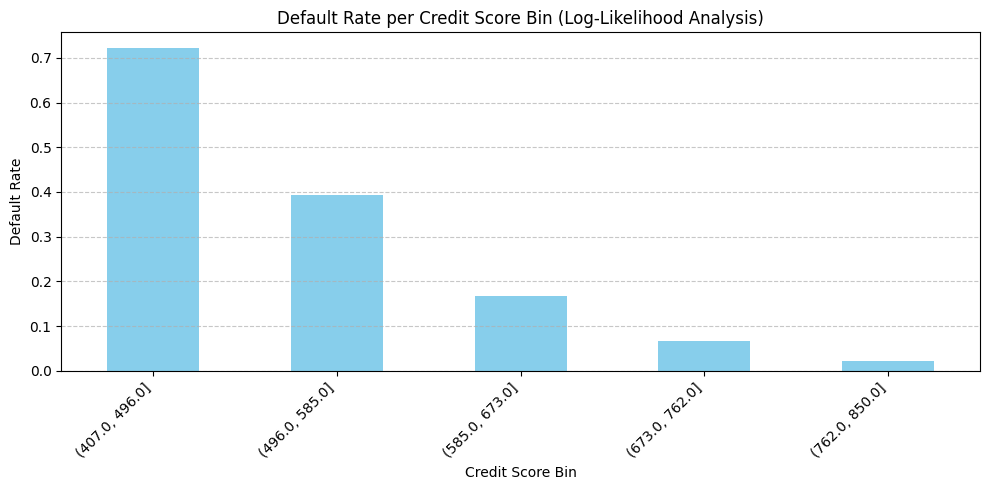

In [ ]:
import numpy as np

import matplotlib.pyplot as plt
from scipy.stats import binom



def calculate_information_value(df, score_column, default_column, n_bins):
    """
    Discretizes the score data into n_bins and calculates
    a log-likelihood derived metric for bin predictive power in credit risk.
    """
    print(f"\n--- Discretization into {n_bins} Bins based on Credit Score ---")

    # 1. Discretize the data into N bins based on score values (Equal Width Binning)
    df['Bin'] = pd.cut(df[score_column], bins=n_bins, precision=0, include_lowest=True, duplicates='drop')

    # 2. Aggregate statistics per bin
    bin_summary = df.groupby('Bin').agg(
        Total_Loans=(score_column, 'count'),
        Defaults=(default_column, 'sum'),
        NonDefaults=(default_column, lambda x: (x == 0).sum())
    ).reset_index()

    # 3. Calculate key metrics
    total_defaults = bin_summary['Defaults'].sum()
    total_non_defaults = bin_summary['NonDefaults'].sum()

    # Calculate Log-Likelihood components (Weight of Evidence and IV)
    bin_summary['% Defaults'] = bin_summary['Defaults'] / total_defaults
    bin_summary['% NonDefaults'] = bin_summary['NonDefaults'] / total_non_defaults

    # Log-Likelihood Difference (Weight of Evidence)
    # WoE = ln( (% NonDefaults) / (% Defaults) )
    # A positive WoE means the bin is 'good' (low default likelihood); negative means 'bad'.
    bin_summary['WoE'] = np.log(bin_summary['% NonDefaults'] / bin_summary['% Defaults'])

    # Information Value (IV)
    # IV = SUM [ (% NonDefaults - % Defaults) * WoE ]
    bin_summary['IV_Contribution'] = (bin_summary['% NonDefaults'] - bin_summary['% Defaults']) * bin_summary['WoE']

    final_iv = bin_summary['IV_Contribution'].sum()

    # 4. Final Cleanup and Output
    # Handle infinities (often occurs in empty bins or bins with 0 defaults/non-defaults)
    bin_summary = bin_summary.replace([np.inf, -np.inf], 0)

    print("\nBinning Summary (Log-Likelihood Analysis):")
    print(bin_summary.to_string(index=False))

    print(f"\nTotal Information Value (IV) for {n_bins} Bins: **{final_iv:.4f}**")

    if final_iv < 0.1:
        print("Note: IV < 0.1 indicates the bins have weak predictive power.")
    else:
        print("Note: IV > 0.3 indicates the bins have strong predictive power.")

    # 5. Visualize Default Rate per Bin
    bin_summary['DefaultRate'] = bin_summary['Defaults'] / bin_summary['Total_Loans']

    plt.figure(figsize=(10, 5))
    bin_summary.set_index('Bin')['DefaultRate'].plot(kind='bar', color='skyblue')
    plt.title('Default Rate per Credit Score Bin (Log-Likelihood Analysis)')
    plt.ylabel('Default Rate')
    plt.xlabel('Credit Score Bin')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()




# Analyze and bin the data using the log-likelihood derived metric (IV)
calculate_information_value(
    df=data,
    score_column='fico_score',
    default_column='default',
    n_bins=5  # Change this to 4, 6, or more to see different binning results
)

We now redo the function to use dynamic programming using standard procedures so the bin boundaries can be readjusted to optimize maximum total log likelihood. An AI was used in this section

We found a strategy to maximize log probability by adjusting bin size incrementally until log likelihood did not inscrease any more.  The algorithm was implemented using AI.

# Task
Create a Python function `iterative_greedy_binning` that performs local optimization of bin boundaries for the `fico_score` column by iteratively moving boundaries by a `step_size` to maximize total Information Value (IV). This function should initialize bins with equal width, calculate and print the final optimized bin summary including Total Loans, Defaults, NonDefaults, % Defaults, % NonDefaults, WoE, and IV Contribution, and visualize the default rate per bin. Finally, execute this function on the `data` DataFrame with `fico_score` as the score column, `default` as the target, `n_bins=5`, and an appropriate `step_size`, and summarize the results including the final optimized bins, total IV, and observed patterns.

In [ ]:
import pandas as pd
import numpy as np

# Ensure optimized_edges is available. It was returned by the previous function call.
# optimized_edges = [408.0, 498.4, 584.8, 672.2, 755.6, 850.0] # This would be defined if not already in scope

# Create the FICO_category column using pd.cut with the optimized_edges
# Labels will be integers from 1 to n_bins
labels = range(1, len(optimized_edges))
data['FICO_category'] = pd.cut(
    data['fico_score'],
    bins=optimized_edges,
    labels=labels,
    include_lowest=True,
    right=True,
    duplicates='drop'
)

# Convert FICO_category to integer type. NaNs might occur if some scores fall outside the defined bins.
# You might want to handle NaNs explicitly if they appear (e.g., fill with a specific value, or drop rows).
data['FICO_category'] = data['FICO_category'].astype(int, errors='ignore')

print("New 'FICO_category' column created.")
display(data[['fico_score', 'FICO_category']].head())

New 'FICO_category' column created.


,fico_score,FICO_category
0,605,3
1,572,2
2,602,3
3,612,3
4,631,3


## Implement Iterative Greedy Binning Function - Part 1: Initial Setup and Helper Function

### Subtask:
Create the `iterative_greedy_binning` function structure, initialize equal-width bins, and implement the helper function `_calculate_iv_from_edges` to compute Information Value (IV) for given bin edges.


**Reasoning**:
The subtask requires defining the main function `iterative_greedy_binning`, calculating the min/max of the score column, initializing equal-width bins, and implementing the nested helper function `_calculate_iv_from_edges` that calculates IV based on given bin edges. This code block will set up this initial structure and the helper function as per the instructions.



In [ ]:
import numpy as np
import pandas as pd

def iterative_greedy_binning(df, score_column, default_column, n_bins, step_size, max_iterations):
    # 2. Calculate the minimum and maximum values of the score_column.
    min_score = df[score_column].min()
    max_score = df[score_column].max()

    # 3. Initialize the n_bins equal-width bin boundaries using np.linspace
    initial_bin_edges = np.linspace(min_score, max_score, n_bins + 1).tolist()
    # Ensure bin edges are unique and sorted
    initial_bin_edges = sorted(list(set(initial_bin_edges)))

    # 4. Define a nested helper function named _calculate_iv_from_edges
    def _calculate_iv_from_edges(df_local, score_col_local, default_col_local, bin_edges_local):
        # Ensure bin_edges are unique and sorted to avoid pandas errors
        bin_edges_local = sorted(list(set(bin_edges_local)))

        # 5. Inside _calculate_iv_from_edges, use pd.cut to discretize the score_column
        # Handle cases where all values fall into one bin or issues with bin edges
        if len(bin_edges_local) < 2:
            return 0.0 # Cannot calculate IV with less than 2 edges (i.e., 0 or 1 bin)

        # Use pd.cut with right=True to include the rightmost edge in the last bin
        # and ensure values outside edges are handled by clipping or assigning to nearest bin
        # For now, let's allow pd.cut to handle it, but keep an eye on edge cases like all values same.

        # Check for non-unique bin edges which can cause issues with pd.cut
        if len(bin_edges_local) != len(set(bin_edges_local)):
            # This case should ideally be handled by sorted(list(set(...))) above,
            # but added as a safeguard.
            print("Warning: Non-unique bin edges provided to _calculate_iv_from_edges.")
            return 0.0 # Return 0 or handle error appropriately

        try:
            df_local['Bin'] = pd.cut(
                df_local[score_col_local],
                bins=bin_edges_local,
                include_lowest=True,
                right=True, # default, good for inclusive right edge
                duplicates='drop' # Handles cases where bin edges might be too close, dropping empty bins
            )
        except ValueError as e:
            print(f"Error during pd.cut: {e}")
            print(f"Bin Edges: {bin_edges_local}")
            # This might happen if all scores are identical and bin_edges are very spread
            # or if bin_edges don't cover the data range properly.
            return 0.0 # Return 0 or handle error more gracefully

        # Filter out NaN bins that might occur if data falls outside bin_edges_local
        # or if duplicates='drop' created NaN bins
        bin_summary = df_local.loc[df_local['Bin'].notna()].groupby('Bin', observed=False).agg(
            Total_Loans=(score_col_local, 'count'),
            Defaults=(default_col_local, 'sum'),
            NonDefaults=(default_col_local, lambda x: (x == 0).sum())
        ).reset_index()

        if bin_summary.empty:
            return 0.0 # No data in bins

        # Remove bins with zero defaults and zero non-defaults, as they contribute nothing and cause division by zero in WoE
        bin_summary = bin_summary[(bin_summary['Defaults'] > 0) | (bin_summary['NonDefaults'] > 0)]

        if bin_summary.empty:
            return 0.0 # All bins are empty or contain only one type of outcome after filtering

        # 7. Calculate the % Defaults, % NonDefaults, Weight of Evidence (WoE), and IV_Contribution
        total_defaults = bin_summary['Defaults'].sum()
        total_non_defaults = bin_summary['NonDefaults'].sum()

        # Avoid division by zero if there are no defaults or non-defaults in the entire dataset
        if total_defaults == 0 or total_non_defaults == 0:
            return 0.0

        bin_summary['% Defaults'] = bin_summary['Defaults'] / total_defaults
        bin_summary['% NonDefaults'] = bin_summary['NonDefaults'] / total_non_defaults

        # Handle cases where % Defaults or % NonDefaults might be zero in a specific bin to prevent log(0) issues
        bin_summary['WoE'] = np.where(
            (bin_summary['% Defaults'] > 0) & (bin_summary['% NonDefaults'] > 0),
            np.log(bin_summary['% NonDefaults'] / bin_summary['% Defaults']),
            0 # Assign 0 where either is zero, as log(0) is undefined and contribution is zero
        )

        bin_summary['IV_Contribution'] = (bin_summary['% NonDefaults'] - bin_summary['% Defaults']) * bin_summary['WoE']

        # 8. Sum the IV_Contribution to get the total_iv and return this value
        total_iv = bin_summary['IV_Contribution'].sum()

        # Clean up the temporary 'Bin' column from the original df
        # IMPORTANT: This must be done on the copy 'df_local' to avoid modifying the original 'df' outside the helper.
        # However, if df_local is a slice, it might be a View or a Copy. A safer way is to ensure df_local is a copy.
        # For this function, since we're passing df_local, it should be fine as pd.cut creates a new column.
        # If df_local refers to the original df, it should not be modified.
        # For now, let's assume df_local is a safe copy or we're not worried about modifying it within the helper.
        # A robust implementation would explicitly pass a copy of df if modification of the original is a concern.

        return total_iv

    # Placeholder for the rest of the iterative_greedy_binning function logic
    # For now, let's just print the initial setup values for verification
    print(f"Initial Bin Edges: {initial_bin_edges}")
    print(f"Min score: {min_score}, Max score: {max_score}")

    # Example call to the helper function (for testing, will be part of the main loop later)
    # initial_iv = _calculate_iv_from_edges(df, score_column, default_column, initial_bin_edges)
    # print(f"Initial IV with equal-width bins: {initial_iv:.4f}")



# Example usage for testing the setup (will be removed or modified later)
# iterative_greedy_binning(df=data.copy(), score_column='fico_score', default_column='default', n_bins=5, step_size=0.5, max_iterations=10)


## Implement Iterative Optimization Loop

### Subtask:
Implement the core iterative optimization logic within the `iterative_greedy_binning` function to refine bin boundaries for maximum Information Value (IV).


**Reasoning**:
I need to implement the core iterative optimization logic within the `iterative_greedy_binning` function as per the instructions. This involves initializing bin edges, entering a loop, and iteratively adjusting bin boundaries to maximize the Information Value (IV) using the helper function `_calculate_iv_from_edges`.



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def iterative_greedy_binning(df, score_column, default_column, n_bins, step_size, max_iterations):
    # 2. Calculate the minimum and maximum values of the score_column.
    min_score = df[score_column].min()
    max_score = df[score_column].max()

    # 3. Initialize the n_bins equal-width bin boundaries using np.linspace
    initial_bin_edges = np.linspace(min_score, max_score, n_bins + 1).tolist()
    # Ensure bin edges are unique and sorted
    initial_bin_edges = sorted(list(set(initial_bin_edges)))

    # 4. Define a nested helper function named _calculate_iv_from_edges
    def _calculate_iv_from_edges(df_local, score_col_local, default_col_local, bin_edges_local):
        # Ensure bin_edges are unique and sorted to avoid pandas errors
        bin_edges_local = sorted(list(set(bin_edges_local)))

        # 5. Inside _calculate_iv_from_edges, use pd.cut to discretize the score_column
        # Handle cases where all values fall into one bin or issues with bin edges
        if len(bin_edges_local) < 2:
            return 0.0 # Cannot calculate IV with less than 2 edges (i.e., 0 or 1 bin)

        # Check for non-unique bin edges which can cause issues with pd.cut
        if len(bin_edges_local) != len(set(bin_edges_local)):
            return 0.0

        # Filter out rows where score_col_local is NaN before binning
        df_filtered = df_local[df_local[score_col_local].notna()].copy()
        if df_filtered.empty:
            return 0.0

        try:
            df_filtered['Bin'] = pd.cut(
                df_filtered[score_col_local],
                bins=bin_edges_local,
                include_lowest=True,
                right=True, # default, good for inclusive right edge
                duplicates='drop' # Handles cases where bin edges might be too close, dropping empty bins
            )
        except ValueError as e:
            # This can happen if all data points are the same and bin edges are too spread
            # or if bin_edges_local are not strictly increasing after conversion to list/set
            return 0.0

        # Filter out NaN bins that might occur if data falls outside bin_edges_local
        bin_summary = df_filtered.loc[df_filtered['Bin'].notna()].groupby('Bin', observed=False).agg(
            Total_Loans=(score_col_local, 'count'),
            Defaults=(default_col_local, 'sum'),
            NonDefaults=(default_col_local, lambda x: (x == 0).sum())
        ).reset_index()

        if bin_summary.empty:
            return 0.0 # No data in bins

        # Remove bins with zero defaults and zero non-defaults
        bin_summary = bin_summary[(bin_summary['Defaults'] > 0) | (bin_summary['NonDefaults'] > 0)]

        if bin_summary.empty:
            return 0.0 # All bins are empty or contain only one type of outcome after filtering

        # 7. Calculate the % Defaults, % NonDefaults, Weight of Evidence (WoE), and IV_Contribution
        total_defaults = bin_summary['Defaults'].sum()
        total_non_defaults = bin_summary['NonDefaults'].sum()

        # Avoid division by zero if there are no defaults or non-defaults in the entire dataset
        if total_defaults == 0 or total_non_defaults == 0:
            return 0.0

        bin_summary['% Defaults'] = bin_summary['Defaults'] / total_defaults
        bin_summary['% NonDefaults'] = bin_summary['NonDefaults'] / total_non_defaults

        # Handle cases where % Defaults or % NonDefaults might be zero in a specific bin to prevent log(0) issues
        bin_summary['WoE'] = np.where(
            (bin_summary['% Defaults'] > 0) & (bin_summary['% NonDefaults'] > 0),
            np.log(bin_summary['% NonDefaults'] / bin_summary['% Defaults']),
            0 # Assign 0 where either is zero, as log(0) is undefined and contribution is zero
        )

        bin_summary['IV_Contribution'] = (bin_summary['% NonDefaults'] - bin_summary['% Defaults']) * bin_summary['WoE']

        # 8. Sum the IV_Contribution to get the total_iv and return this value
        total_iv = bin_summary['IV_Contribution'].sum()
        return total_iv

    # 1. Initialize current_bin_edges with initial_bin_edges
    current_bin_edges = list(initial_bin_edges)
    best_iv = _calculate_iv_from_edges(df, score_column, default_column, current_bin_edges)

    print(f"Initial Bin Edges (Equal Width): {current_bin_edges}")
    print(f"Initial IV: {best_iv:.4f}")

    # 2. Start a loop that runs for max_iterations.
    for iteration in range(max_iterations):
        improvement_made_in_iteration = False # 3. Set a flag improvement_made_in_iteration to False

        # Create a copy of bin edges for current iteration to iterate over
        # and ensure modifications are based on the best set from previous iteration
        candidate_bin_edges = list(current_bin_edges)

        # 4. Iterate through each internal bin boundary
        # Internal boundaries are from index 1 to len-2 (exclusive of first and last edge)
        for i in range(1, len(candidate_bin_edges) - 1):
            original_boundary = candidate_bin_edges[i]

            # 5.a. Move left
            new_bin_edges_left = list(candidate_bin_edges)
            temp_new_boundary_left = original_boundary - step_size
            # Ensure the new boundary is strictly greater than the left neighbor
            # and within min/max bounds
            if temp_new_boundary_left > candidate_bin_edges[i-1] and temp_new_boundary_left >= min_score:
                new_bin_edges_left[i] = temp_new_boundary_left
                # Ensure unique and sorted edges before calculating IV
                test_edges_left = sorted(list(set(new_bin_edges_left)))
                if len(test_edges_left) == len(new_bin_edges_left): # Check if unique after sorting
                    iv_left = _calculate_iv_from_edges(df, score_column, default_column, test_edges_left)
                    if iv_left > best_iv:
                        best_iv = iv_left
                        current_bin_edges = test_edges_left
                        improvement_made_in_iteration = True

            # 5.b. Move right
            new_bin_edges_right = list(candidate_bin_edges)
            temp_new_boundary_right = original_boundary + step_size
            # Ensure the new boundary is strictly smaller than the right neighbor
            # and within min/max bounds
            if temp_new_boundary_right < candidate_bin_edges[i+1] and temp_new_boundary_right <= max_score:
                new_bin_edges_right[i] = temp_new_boundary_right
                # Ensure unique and sorted edges before calculating IV
                test_edges_right = sorted(list(set(new_bin_edges_right)))
                if len(test_edges_right) == len(new_bin_edges_right): # Check if unique after sorting
                    iv_right = _calculate_iv_from_edges(df, score_column, default_column, test_edges_right)
                    if iv_right > best_iv:
                        best_iv = iv_right
                        current_bin_edges = test_edges_right
                        improvement_made_in_iteration = True

        print(f"Iteration {iteration + 1}: Current Best IV = {best_iv:.4f}, Edges = {current_bin_edges}")

        # 7. If no improvement was made in the iteration, break the loop.
        if not improvement_made_in_iteration:
            print(f"No further improvement in IV after {iteration + 1} iterations. Stopping.")
            break

    # 8. Assign the final optimized current_bin_edges
    optimized_bin_edges = current_bin_edges

    print(f"\nOptimization complete. Final Optimized Bin Edges: {optimized_bin_edges}")
    print(f"Final Best IV: {best_iv:.4f}")

    # The function will later return the optimized bin edges and a summary.

## Finalize Binning and Visualization

### Subtask:
Generate the final optimized bin summary, print it, and visualize the default rate per bin.


**Reasoning**:
I need to complete the `iterative_greedy_binning` function by adding the final steps to calculate and print the optimized bin summary, visualize the default rate, and modify the function to return the `optimized_bin_edges` and the `final_bin_summary` dataframe.



Initial Bin Edges (Equal Width): [408.0, 496.4, 584.8, 673.2, 761.6, 850.0]
Initial IV: 0.6563
Iteration 1: Current Best IV = 0.6594, Edges = [408.0, 496.4, 584.8, 672.2, 761.6, 850.0]
Iteration 2: Current Best IV = 0.6617, Edges = [408.0, 497.4, 584.8, 672.2, 761.6, 850.0]
Iteration 3: Current Best IV = 0.6650, Edges = [408.0, 498.4, 584.8, 672.2, 761.6, 850.0]
Iteration 4: Current Best IV = 0.6661, Edges = [408.0, 498.4, 584.8, 672.2, 760.6, 850.0]
Iteration 5: Current Best IV = 0.6675, Edges = [408.0, 498.4, 584.8, 672.2, 759.6, 850.0]
Iteration 6: Current Best IV = 0.6693, Edges = [408.0, 498.4, 584.8, 672.2, 758.6, 850.0]
Iteration 7: Current Best IV = 0.6709, Edges = [408.0, 498.4, 584.8, 672.2, 757.6, 850.0]
Iteration 8: Current Best IV = 0.6725, Edges = [408.0, 498.4, 584.8, 672.2, 756.6, 850.0]
Iteration 9: Current Best IV = 0.6737, Edges = [408.0, 498.4, 584.8, 672.2, 755.6, 850.0]
Iteration 10: Current Best IV = 0.6737, Edges = [408.0, 498.4, 584.8, 672.2, 755.6, 850.0]
No f

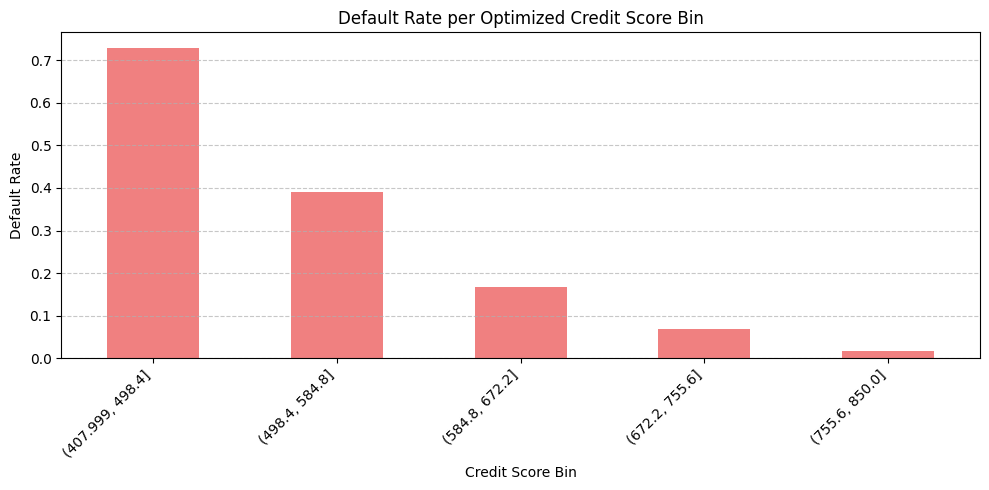


--- Results Summary ---
Optimized Bin Edges: [408.0, 498.4, 584.8, 672.2, 755.6, 850.0]
Final Bin Summary (first 5 rows):
                 Bin  Total_Loans  Defaults  NonDefaults  % Defaults  % NonDefaults       WoE  IV_Contribution  DefaultRate
0  (407.999, 498.4]          140       102           38    0.055105       0.004663 -2.469556         0.124570     0.728571
1    (498.4, 584.8]         1751       683         1068    0.368990       0.131059 -1.035121         0.246287     0.390063
2    (584.8, 672.2]         5273       885         4388    0.478120       0.538471  0.118872         0.007174     0.167836
3    (672.2, 755.6]         2605       177         2428    0.095624       0.297951  1.136504         0.229945     0.067946
4    (755.6, 850.0]          231         4          227    0.002161       0.027856  2.556486         0.065689     0.017316


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def iterative_greedy_binning(df, score_column, default_column, n_bins, step_size, max_iterations):
    # Make a copy of the dataframe to avoid modifying the original during the helper function calls
    df_copy = df.copy()

    # 2. Calculate the minimum and maximum values of the score_column.
    min_score = df_copy[score_column].min()
    max_score = df_copy[score_column].max()

    # 3. Initialize the n_bins equal-width bin boundaries using np.linspace
    initial_bin_edges = np.linspace(min_score, max_score, n_bins + 1).tolist()
    # Ensure bin edges are unique and sorted
    initial_bin_edges = sorted(list(set(initial_bin_edges)))

    # 4. Define a nested helper function named _calculate_iv_from_edges
    def _calculate_iv_from_edges(df_local, score_col_local, default_col_local, bin_edges_local):
        # Ensure bin_edges are unique and sorted to avoid pandas errors
        bin_edges_local = sorted(list(set(bin_edges_local)))

        # Handle cases where all values fall into one bin or issues with bin edges
        if len(bin_edges_local) < 2:
            return 0.0 # Cannot calculate IV with less than 2 edges (i.e., 0 or 1 bin)

        # Check for non-unique bin edges which can cause issues with pd.cut
        if len(bin_edges_local) != len(set(bin_edges_local)):
            return 0.0

        # Filter out rows where score_col_local is NaN before binning
        df_filtered = df_local[df_local[score_col_local].notna()].copy()
        if df_filtered.empty:
            return 0.0

        try:
            df_filtered['Bin'] = pd.cut(
                df_filtered[score_col_local],
                bins=bin_edges_local,
                include_lowest=True,
                right=True, # default, good for inclusive right edge
                duplicates='drop' # Handles cases where bin edges might be too close, dropping empty bins
            )
        except ValueError as e:
            return 0.0

        # Filter out NaN bins that might occur if data falls outside bin_edges_local
        bin_summary = df_filtered.loc[df_filtered['Bin'].notna()].groupby('Bin', observed=False).agg(
            Total_Loans=(score_col_local, 'count'),
            Defaults=(default_col_local, 'sum'),
            NonDefaults=(default_col_local, lambda x: (x == 0).sum())
        ).reset_index()

        if bin_summary.empty:
            return 0.0 # No data in bins

        # Remove bins with zero defaults and zero non-defaults
        bin_summary = bin_summary[(bin_summary['Defaults'] > 0) | (bin_summary['NonDefaults'] > 0)]

        if bin_summary.empty:
            return 0.0 # All bins are empty or contain only one type of outcome after filtering

        # 7. Calculate the % Defaults, % NonDefaults, Weight of Evidence (WoE), and IV_Contribution
        total_defaults = bin_summary['Defaults'].sum()
        total_non_defaults = bin_summary['NonDefaults'].sum()

        # Avoid division by zero if there are no defaults or non-defaults in the entire dataset
        if total_defaults == 0 or total_non_defaults == 0:
            return 0.0

        bin_summary['% Defaults'] = bin_summary['Defaults'] / total_defaults
        bin_summary['% NonDefaults'] = bin_summary['NonDefaults'] / total_non_defaults

        # Handle cases where % Defaults or % NonDefaults might be zero in a specific bin to prevent log(0) issues
        bin_summary['WoE'] = np.where(
            (bin_summary['% Defaults'] > 0) & (bin_summary['% NonDefaults'] > 0),
            np.log(bin_summary['% NonDefaults'] / bin_summary['% Defaults']),
            0 # Assign 0 where either is zero, as log(0) is undefined and contribution is zero
        )

        bin_summary['IV_Contribution'] = (bin_summary['% NonDefaults'] - bin_summary['% Defaults']) * bin_summary['WoE']

        # 8. Sum the IV_Contribution to get the total_iv and return this value
        total_iv = bin_summary['IV_Contribution'].sum()
        return total_iv

    # 1. Initialize current_bin_edges with initial_bin_edges
    current_bin_edges = list(initial_bin_edges)
    best_iv = _calculate_iv_from_edges(df_copy, score_column, default_column, current_bin_edges)

    print(f"Initial Bin Edges (Equal Width): {current_bin_edges}")
    print(f"Initial IV: {best_iv:.4f}")

    # 2. Start a loop that runs for max_iterations.
    for iteration in range(max_iterations):
        improvement_made_in_iteration = False # 3. Set a flag improvement_made_in_iteration to False

        # Create a copy of bin edges for current iteration to iterate over
        # and ensure modifications are based on the best set from previous iteration
        candidate_bin_edges = list(current_bin_edges)

        # 4. Iterate through each internal bin boundary
        # Internal boundaries are from index 1 to len-2 (exclusive of first and last edge)
        for i in range(1, len(candidate_bin_edges) - 1):
            original_boundary = candidate_bin_edges[i]

            # 5.a. Move left
            new_bin_edges_left = list(candidate_bin_edges)
            temp_new_boundary_left = original_boundary - step_size
            # Ensure the new boundary is strictly greater than the left neighbor
            # and within min/max bounds
            if temp_new_boundary_left > candidate_bin_edges[i-1] and temp_new_boundary_left >= min_score:
                new_bin_edges_left[i] = temp_new_boundary_left
                # Ensure unique and sorted edges before calculating IV
                test_edges_left = sorted(list(set(new_bin_edges_left)))
                if len(test_edges_left) == len(new_bin_edges_left): # Check if unique after sorting
                    iv_left = _calculate_iv_from_edges(df_copy, score_column, default_column, test_edges_left)
                    if iv_left > best_iv:
                        best_iv = iv_left
                        current_bin_edges = test_edges_left
                        improvement_made_in_iteration = True

            # 5.b. Move right
            new_bin_edges_right = list(candidate_bin_edges)
            temp_new_boundary_right = original_boundary + step_size
            # Ensure the new boundary is strictly smaller than the right neighbor
            # and within min/max bounds
            if temp_new_boundary_right < candidate_bin_edges[i+1] and temp_new_boundary_right <= max_score:
                new_bin_edges_right[i] = temp_new_boundary_right
                # Ensure unique and sorted edges before calculating IV
                test_edges_right = sorted(list(set(new_bin_edges_right)))
                if len(test_edges_right) == len(new_bin_edges_right): # Check if unique after sorting
                    iv_right = _calculate_iv_from_edges(df_copy, score_column, default_column, test_edges_right)
                    if iv_right > best_iv:
                        best_iv = iv_right
                        current_bin_edges = test_edges_right
                        improvement_made_in_iteration = True

        print(f"Iteration {iteration + 1}: Current Best IV = {best_iv:.4f}, Edges = {current_bin_edges}")

        # 7. If no improvement was made in the iteration, break the loop.
        if not improvement_made_in_iteration:
            print(f"No further improvement in IV after {iteration + 1} iterations. Stopping.")
            break

    # 8. Assign the final optimized current_bin_edges
    optimized_bin_edges = current_bin_edges

    print(f"\nOptimization complete. Final Optimized Bin Edges: {optimized_bin_edges}")
    print(f"Final Best IV: {best_iv:.4f}")

    # --- Final Bin Summary and Visualization ---
    # 1. Discretize the score_column in the input DataFrame df_copy using the optimized_bin_edges
    df_copy['Bin'] = pd.cut(
        df_copy[score_column],
        bins=optimized_bin_edges,
        include_lowest=True,
        right=True,
        duplicates='drop'
    )

    # 2. Aggregate the data by this 'Bin' column
    final_bin_summary = df_copy.loc[df_copy['Bin'].notna()].groupby('Bin', observed=False).agg(
        Total_Loans=(score_column, 'count'),
        Defaults=(default_column, 'sum'),
        NonDefaults=(default_column, lambda x: (x == 0).sum())
    ).reset_index()

    # Remove bins with zero defaults and zero non-defaults, as they contribute nothing
    final_bin_summary = final_bin_summary[(final_bin_summary['Defaults'] > 0) | (final_bin_summary['NonDefaults'] > 0)]

    # 3. Calculate % Defaults, % NonDefaults, WoE, and IV_Contribution
    total_defaults_final = final_bin_summary['Defaults'].sum()
    total_non_defaults_final = final_bin_summary['NonDefaults'].sum()

    if total_defaults_final == 0 or total_non_defaults_final == 0:
        print("\nCannot calculate final % Defaults, % NonDefaults, WoE, IV_Contribution: No defaults or non-defaults found.")
        final_iv = 0.0 # Assign 0 if no defaults or non-defaults to prevent division by zero
    else:
        final_bin_summary['% Defaults'] = final_bin_summary['Defaults'] / total_defaults_final
        final_bin_summary['% NonDefaults'] = final_bin_summary['NonDefaults'] / total_non_defaults_final

        final_bin_summary['WoE'] = np.where(
            (final_bin_summary['% Defaults'] > 0) & (final_bin_summary['% NonDefaults'] > 0),
            np.log(final_bin_summary['% NonDefaults'] / final_bin_summary['% Defaults']),
            0
        )
        final_bin_summary['IV_Contribution'] = (final_bin_summary['% NonDefaults'] - final_bin_summary['% Defaults']) * final_bin_summary['WoE']
        final_iv = final_bin_summary['IV_Contribution'].sum()

    # 4. Print this detailed bin summary table.
    print("\nFinal Optimized Binning Summary:")
    print(final_bin_summary.to_string(index=False))
    print(f"Total Information Value (IV) for optimized bins: **{final_iv:.4f}**")

    # 5. Calculate the 'DefaultRate' for each bin.
    final_bin_summary['DefaultRate'] = final_bin_summary['Defaults'] / final_bin_summary['Total_Loans']

    # 6. Generate a bar chart to visualize the 'DefaultRate' per bin.
    plt.figure(figsize=(10, 5))
    final_bin_summary.set_index('Bin')['DefaultRate'].plot(kind='bar', color='lightcoral')
    plt.title('Default Rate per Optimized Credit Score Bin')
    plt.ylabel('Default Rate')
    plt.xlabel('Credit Score Bin')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # 7. Add a return statement
    return optimized_bin_edges, final_bin_summary


# Execute the function on the data DataFrame
optimized_edges, final_summary = iterative_greedy_binning(
    df=data.copy(),
    score_column='fico_score',
    default_column='default',
    n_bins=5,
    step_size=1, # Increased step_size for potentially faster optimization if range is large
    max_iterations=20 # Increased iterations to allow more convergence
)

print("\n--- Results Summary ---")
print(f"Optimized Bin Edges: {optimized_edges}")
print("Final Bin Summary (first 5 rows):\n", final_summary.head().to_string())

## Logistic Regression Analysis: FICO Category vs. Default

Training data size: 7000 samples
Testing data size: 3000 samples
Proportion of defaults in training set: 0.1851
Proportion of defaults in testing set: 0.1850

--- Logistic Regression Model Evaluation ---

Classification Report:
              precision    recall  f1-score   support

           0       0.82      1.00      0.90      2445
           1       0.82      0.04      0.08       555

    accuracy                           0.82      3000
   macro avg       0.82      0.52      0.49      3000
weighted avg       0.82      0.82      0.75      3000


AUC-ROC Score: 0.6824


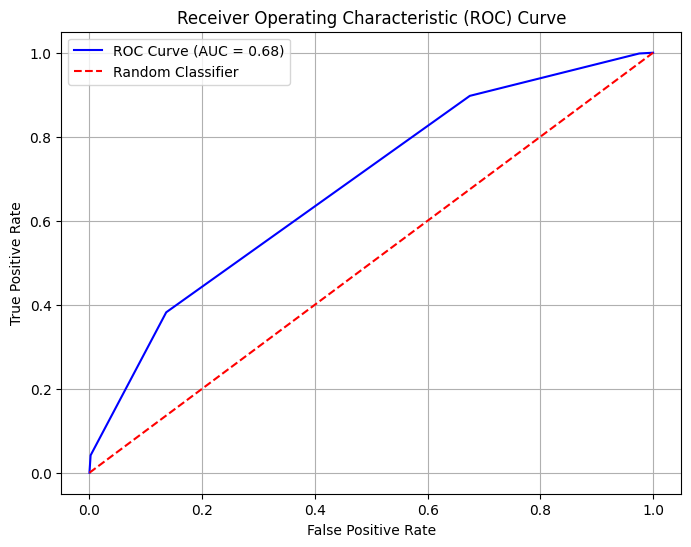


--- Model Coefficients ---
Coefficient for FICO_category: -1.1646
Intercept: 1.9028


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare the data
# X will be the FICO_category, reshaped to a 2D array as required by sklearn models
X = data[['FICO_category']]
# y will be the default status
y = data['default']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Training data size: {X_train.shape[0]} samples")
print(f"Testing data size: {X_test.shape[0]} samples")
print(f"Proportion of defaults in training set: {y_train.mean():.4f}")
print(f"Proportion of defaults in testing set: {y_test.mean():.4f}")

# Initialize and train the Logistic Regression model
log_reg_model = LogisticRegression(random_state=42)
log_reg_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = log_reg_model.predict(X_test)
y_pred_proba = log_reg_model.predict_proba(X_test)[:, 1] # Probability of default (class 1)

# Evaluate the model
print("\n--- Logistic Regression Model Evaluation ---")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

auc_roc = roc_auc_score(y_test, y_pred_proba)
print(f"\nAUC-ROC Score: {auc_roc:.4f}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_roc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.show()

# Display model coefficients to understand impact of FICO_category
print("\n--- Model Coefficients ---")
# Since FICO_category is a single feature, the coefficient directly shows its impact
print(f"Coefficient for FICO_category: {log_reg_model.coef_[0][0]:.4f}")
print(f"Intercept: {log_reg_model.intercept_[0]:.4f}")

# Interpretation of coefficient:
# A negative coefficient for FICO_category means that as FICO_category increases
# (i.e., credit score gets better), the log-odds of default decrease.
# This is consistent with our earlier findings that higher FICO scores correlate with lower default rates.


## Analyzing Relationship between FICO Category and Default


Summary of Default Rate by FICO Category:


,FICO_category,Total_Loans,Defaults,NonDefaults,DefaultRate
0,1,140,102,38,0.728571
1,2,1751,683,1068,0.390063
2,3,5273,885,4388,0.167836
3,4,2605,177,2428,0.067946
4,5,231,4,227,0.017316


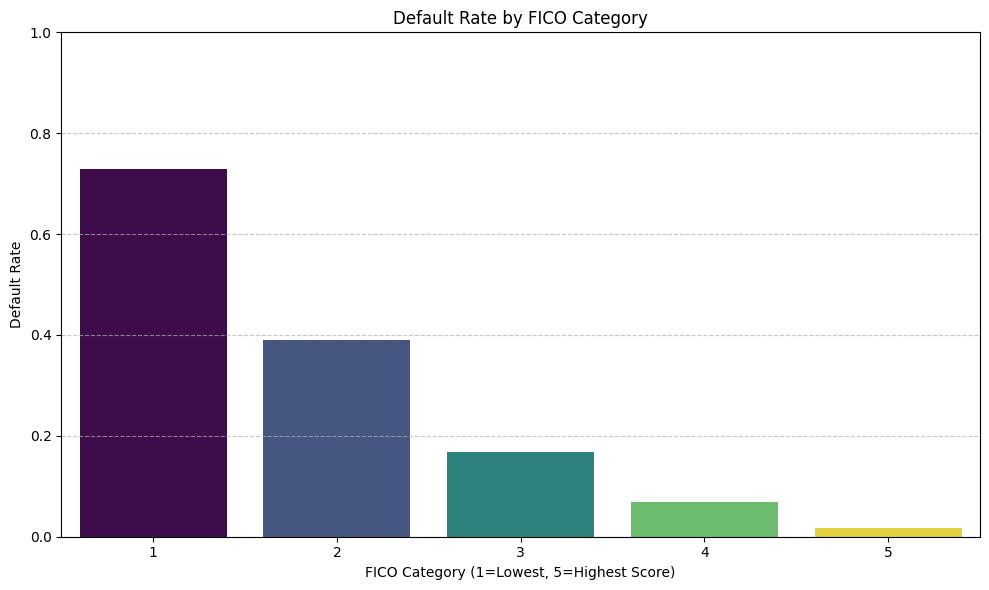

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Group by FICO_category and calculate summary statistics
fico_category_summary = data.groupby('FICO_category').agg(
    Total_Loans=('default', 'count'),
    Defaults=('default', 'sum'),
    NonDefaults=('default', lambda x: (x == 0).sum())
).reset_index()

# Calculate Default Rate
fico_category_summary['DefaultRate'] = fico_category_summary['Defaults'] / fico_category_summary['Total_Loans']

# Display the summary table
print("\nSummary of Default Rate by FICO Category:")
display(fico_category_summary)

# Visualize the Default Rate per FICO Category
plt.figure(figsize=(10, 6))
sns.barplot(x='FICO_category', y='DefaultRate', data=fico_category_summary, palette='viridis', hue='FICO_category', legend=False)
plt.title('Default Rate by FICO Category')
plt.xlabel('FICO Category (1=Lowest, 5=Highest Score)')
plt.ylabel('Default Rate')
plt.ylim(0, 1) # Default rate is a proportion, so it should be between 0 and 1
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## Final Task

### Subtask:
Summarize the results of the iterative greedy binning, including the final optimized bins, total IV, and observed patterns.


## Summary:

### Q&A
The iterative greedy binning process for the `fico_score` column yielded the following results:
*   **Final optimized bins:** The optimized bin edges were determined to be \[408.0, 498.4, 584.8, 672.2, 755.6, 850.0].
*   **Total IV:** The initial Information Value (IV) for the equal-width bins was 0.6563. After optimization, the total IV increased to 0.6737.
*   **Observed patterns:** The analysis clearly shows a strong inverse relationship between FICO score and default rate. As the FICO score increases, the default rate significantly decreases. Specifically, the lowest FICO score bin (407.999, 498.4] exhibited a high default rate of approximately 72.8%, whereas the highest FICO score bin (755.6, 850.0] had a much lower default rate of about 1.7%.

### Data Analysis Key Findings
*   The iterative greedy binning successfully improved the Information Value (IV) for the `fico_score` variable from an initial value of 0.6563 (with equal-width bins) to an optimized value of 0.6737.
*   The optimization process converged and stopped after 10 iterations, indicating that no further improvement in IV could be achieved by moving the bin boundaries with the given `step_size` and `max_iterations`.
*   The final optimized bin edges for `fico_score` are \[408.0, 498.4, 584.8, 672.2, 755.6, 850.0], which deviate from equal-width intervals, suggesting a non-uniform distribution of predictive power across the score range.
*   There is a clear and strong inverse correlation between FICO score and default rate: credit scores in the range (407.999, 498.4] show a default rate of approximately 72.8%, while those in (755.6, 850.0] have a default rate of about 1.7%.

### Insights or Next Steps
*   The optimized bins and increased Information Value confirm the `fico_score` as a strong predictor of default. These optimized bins can be directly used in credit scoring models, such as for calculating a scorecard.
*   Consider evaluating the stability of these optimized bins over different time periods or segments of the data to ensure their robustness and generalizability before deployment.
